In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '50 percent More buy CNN Images Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  lab

In [6]:
r_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  la

## Train Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


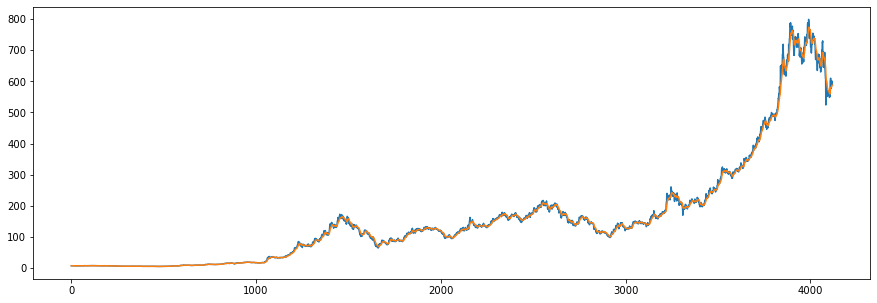

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


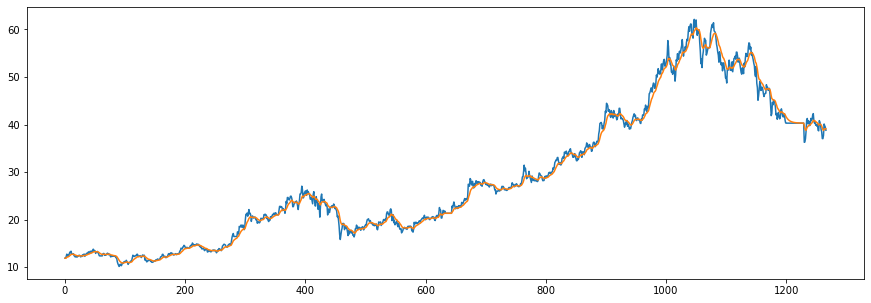

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     4.396951  4.259450 -20.237909   91957609.0     2.0
2000-01-25     4.523540  4.300079 -16.033642  115224048.0     2.0
2000-01-26     4.400991  4.315604 -35.231971  105394663.0     2.0
2000-01-27     4.399644  4.328533 -51.735021   77180955.0     2.0
2000-01-28     4.302682  4.324556 -63.091500   43145413.0     2.0


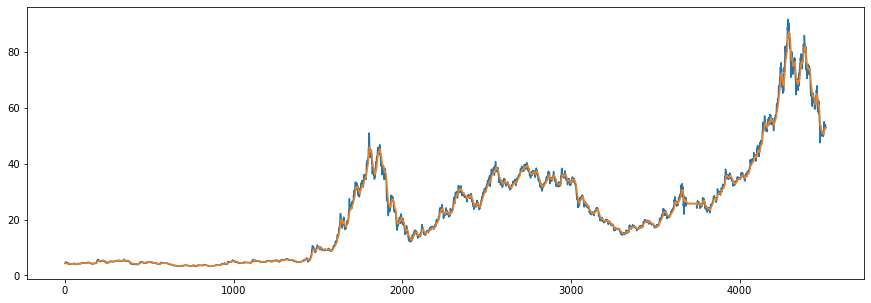

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-06-30        2.575  2.436754 -19.047606  495757896.0     2.0
2004-07-01        2.525  2.450330 -33.333298  480565876.0     2.0
2004-07-02        2.525  2.461818 -33.333298  480565876.0     2.0
2004-07-05        2.550  2.475385 -27.777775  505227876.0     2.0
2004-07-06        2.550  2.486864 -27.777775  505227876.0     2.0


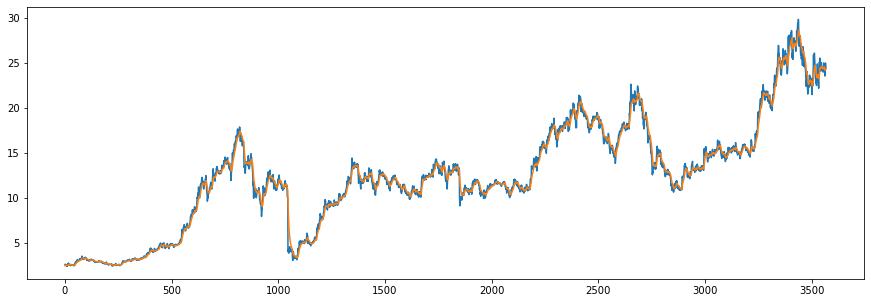

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      50.0000  47.379245 -27.700831  21139400.0     2.0
2000-01-24      48.5000  47.551669 -40.997230  17619200.0     2.0
2000-01-25      47.0000  47.466797 -54.293629  12613700.0     2.0
2000-01-26      49.6875  47.808444 -30.470914  16344500.0     2.0
2000-01-27      50.4375  48.212914 -27.215190  20127300.0     2.0


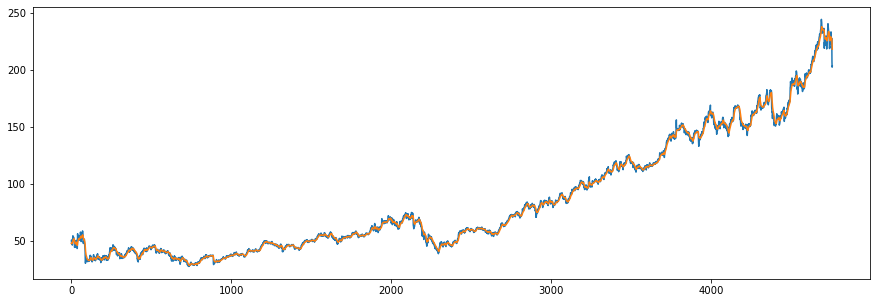

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21     56.28125  56.412106 -36.614173 -25968400.0     2.0
2000-01-24     51.34375  55.632359 -83.112583 -50347200.0     2.0
2000-01-25     51.56250  55.006226 -64.721485 -21792600.0     1.0
2000-01-26     48.75000  54.043730 -88.594164 -38890400.0     2.0
2000-01-27     50.31250  53.469695 -75.331565 -28647200.0     2.0


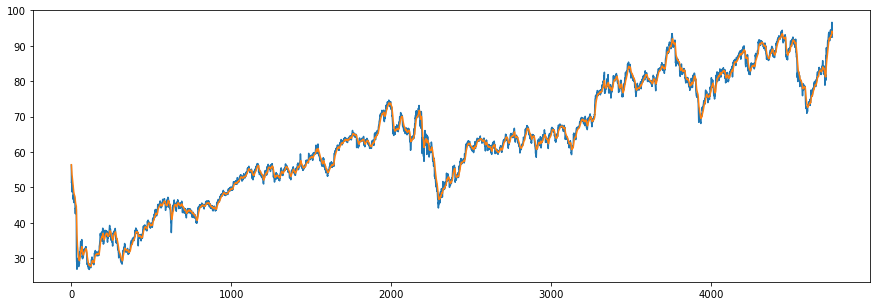

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


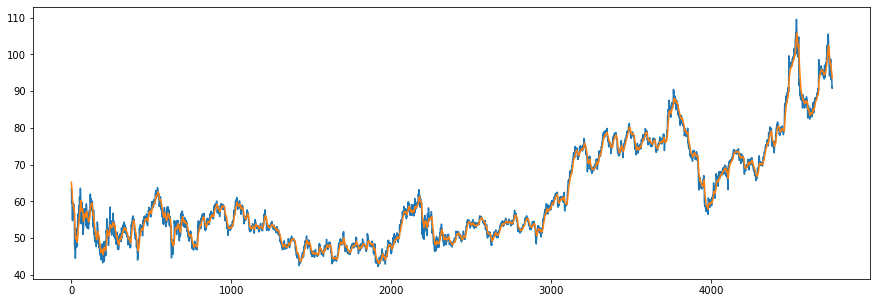

In [10]:
sequential_data = []
labels = []

train_sets = ['600519.SS','000333.SZ','000858.SZ','2319.HK','COST','PG','WMT']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1
            
    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
        
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()

In [11]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(27645, 64, 64, 1)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 25128, 1.0: 1252, 0.0: 1265})

In [13]:
X = sequential_data
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:626]
class_1 = class_1[0:1252]
class_2 = class_2[0:626]

class_0_labels = class_0_labels[0:626]
class_1_labels = class_1_labels[0:1252]
class_2_labels = class_2_labels[0:626]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

print(X.shape)

Counter(y)

(2504, 64, 64, 1)


Counter({0.0: 626, 1.0: 1252, 2.0: 626})

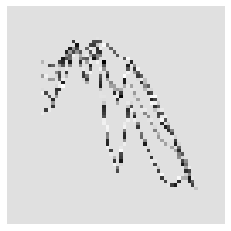

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['600519.SS','000333.SZ','WMT','FDP']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 1 1 ... 1 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 1.332667997338656, 1: 0.666999666999667, 2: 1.332667997338656}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/16 [>.............................] - ETA: 0s - loss: 0.4704 - accuracy: 0.2500 - mse: 6.1466 - weighted_accuracy: 0.2974 - weighted_mse: 5.9126WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
16/16 [==============================] - 1s 34ms/step - loss: 0.2553 - accuracy: 0.3270 - mse: 1.9309 - weighted_accuracy: 0.3494 - weighted_mse: 1.9058 - val_loss: 0.2042 - val_accuracy: 0.2495 - val_mse: 0.9337 - val_weighted_accuracy: 0.2495 - val_weighted_mse: 0.9337
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.2084 - accuracy: 0.3305 - mse: 1.1335 - weighted_accuracy: 0.3205 - weighted_mse: 1.1370 - val_loss: 0.1958 - v

7/7 [==============================] - 0s 5ms/step - loss: 0.1964 - accuracy: 0.1346 - mse: 0.9937 - weighted_accuracy: 0.1346 - weighted_mse: 0.9937
Test loss: 0.19643238186836243
Test accuracy: 0.13461539149284363


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 54
actual holds but predicted sell: 121
actual predicted holds: 14
Percentage buys correct: 9.836065573770492%
Percentage sells correct: 6.106870229007634%
Percentage holds correct: 87.5%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 52.459016393442624%
Percentage high sells correct: 49.23076923076923%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase from previou

7/7 [==============================] - 0s 2ms/step - loss: 0.1969 - accuracy: 0.1346 - mse: 1.0156 - weighted_accuracy: 0.1346 - weighted_mse: 1.0156
Test loss: 0.1968580037355423
Test accuracy: 0.13461539149284363


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 55
actual holds but predicted sell: 121
actual predicted holds: 17
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 3.9682539682539684%
Percentage holds correct: 89.47368421052632%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 53.96825396825397%
Percentage high sells correct: 49.6%
Percentage mid holds correct: 89.47368421052632%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase fro

7/7 [==============================] - 0s 5ms/step - loss: 0.1930 - accuracy: 0.1689 - mse: 1.0214 - weighted_accuracy: 0.1689 - weighted_mse: 1.0214
Test loss: 0.19303473830223083
Test accuracy: 0.16894976794719696


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 86
actual holds but predicted sell: 91
actual predicted holds: 24
Percentage buys correct: 5.319148936170213%
Percentage sells correct: 7.920792079207921%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 47.87234042553192%
Percentage high sells correct: 45.54455445544554%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase fr

3           5.320149  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1963 - accuracy: 0.2055 - mse: 1.0190 - weighted_accuracy: 0.2055 - weighted_mse: 1.0190
Test loss: 0.1962924301624298
Test accuracy: 0.2054794579744339


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 52
actual holds but predicted sell: 112
actual predicted holds: 35
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 5.737704918032787%
Percentage holds correct: 87.5%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 44.26229508196721%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.5285652030654422
Shares owned at the moment: 188
Cash capital at the moment: $0.356473613

16/16 [==============================] - 0s 9ms/step - loss: 0.1853 - accuracy: 0.5317 - mse: 1.2750 - weighted_accuracy: 0.4902 - weighted_mse: 1.2687 - val_loss: 0.1744 - val_accuracy: 0.6008 - val_mse: 0.9719 - val_weighted_accuracy: 0.6008 - val_weighted_mse: 0.9719
Epoch 12/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1846 - accuracy: 0.5217 - mse: 1.2567 - weighted_accuracy: 0.4793 - weighted_mse: 1.2523 - val_loss: 0.1758 - val_accuracy: 0.5888 - val_mse: 0.9536 - val_weighted_accuracy: 0.5888 - val_weighted_mse: 0.9536
Epoch 13/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1844 - accuracy: 0.5372 - mse: 1.2914 - weighted_accuracy: 0.4926 - weighted_mse: 1.2802 - val_loss: 0.1682 - val_accuracy: 0.6048 - val_mse: 1.0706 - val_weighted_accuracy: 0.6048 - val_weighted_mse: 1.0706
Epoch 14/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1841 - accuracy: 0.5307 - mse: 1.2615 - weighted_accuracy: 0.4902 - weighted_mse: 1.2548

7/7 [==============================] - 0s 2ms/step - loss: 0.2098 - accuracy: 0.0865 - mse: 1.1679 - weighted_accuracy: 0.0865 - weighted_mse: 1.1679
Test loss: 0.20984068512916565
Test accuracy: 0.08653846383094788


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 69
actual holds but predicted sell: 120
actual predicted holds: 0
Percentage buys correct: 11.39240506329114%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 49.36708860759494%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 19.361284

7/7 [==============================] - 0s 2ms/step - loss: 0.2123 - accuracy: 0.0673 - mse: 1.2136 - weighted_accuracy: 0.0673 - weighted_mse: 1.2136
Test loss: 0.212349072098732
Test accuracy: 0.06730769574642181


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 85
actual holds but predicted sell: 108
actual predicted holds: 0
Percentage buys correct: 7.526881720430108%
Percentage sells correct: 6.086956521739131%
Percentage holds correct: 0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 53.763440860215056%
Percentage high sells correct: 53.50877192982456%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously bought

7/7 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.0594 - mse: 1.1694 - weighted_accuracy: 0.0594 - weighted_mse: 1.1694
Test loss: 0.2073761224746704
Test accuracy: 0.05936073139309883


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 117
actual holds but predicted sell: 84
actual predicted holds: 0
Percentage buys correct: 4.0%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 45.744680851063826%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.2847230626280439
Shares owned at the moment: 350
Cash capital at the moment: $0.07288213240512675


Price increase from previously bought: 2.959521836376755%
Share p

7/7 [==============================] - 0s 2ms/step - loss: 0.2104 - accuracy: 0.0639 - mse: 1.1610 - weighted_accuracy: 0.0639 - weighted_mse: 1.1610
Test loss: 0.21040642261505127
Test accuracy: 0.06392694264650345


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 94
actual holds but predicted sell: 105
actual predicted holds: 0
Percentage buys correct: 6.730769230769231%
Percentage sells correct: 6.086956521739131%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 50.48543689320388%
Percentage high sells correct: 42.608695652173914%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.5059094027261046
Shares owned at the moment: 197
Cash capital at the moment: $0.06177124403052403


Price increase from previously boug

16/16 [==============================] - 0s 9ms/step - loss: 0.1799 - accuracy: 0.5557 - mse: 1.2948 - weighted_accuracy: 0.5172 - weighted_mse: 1.2991 - val_loss: 0.1655 - val_accuracy: 0.6327 - val_mse: 1.0197 - val_weighted_accuracy: 0.6327 - val_weighted_mse: 1.0197
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1794 - accuracy: 0.5497 - mse: 1.3235 - weighted_accuracy: 0.5055 - weighted_mse: 1.3086 - val_loss: 0.1675 - val_accuracy: 0.6048 - val_mse: 1.0530 - val_weighted_accuracy: 0.6048 - val_weighted_mse: 1.0530
Epoch 4/20
16/16 [==============================] - 0s 10ms/step - loss: 0.1802 - accuracy: 0.5392 - mse: 1.3066 - weighted_accuracy: 0.5062 - weighted_mse: 1.3031 - val_loss: 0.1697 - val_accuracy: 0.6008 - val_mse: 1.0431 - val_weighted_accuracy: 0.6008 - val_weighted_mse: 1.0431
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1791 - accuracy: 0.5602 - mse: 1.2989 - weighted_accuracy: 0.5195 - weighted_mse: 1.2950 -

Share price: $0.5181791863817551
Shares owned at the moment: 3300
Cash capital at the moment: $0.3266754837698045


Price increase from previously bought: -2.2493915412006293%
Share price: $0.507916246690908
Shares owned at the moment: 0
Cash capital at the moment: $1671.840949625046


Share price: $0.4924732229795521
Shares owned at the moment: 3385
Cash capital at the moment: $0.23477972485125065


Price increase from previously bought: 3.042245523618292%
Share price: $0.5088509700964581
Shares owned at the moment: 0
Cash capital at the moment: $1717.9585470334764


Share price: $0.4426776877814631
Shares owned at the moment: 3870
Cash capital at the moment: $0.0846980269998312


Price increase from previously bought: 33.15559351972512%
Share price: $0.591071090326801
Shares owned at the moment: 0
Cash capital at the moment: $2281.239343512917


Share price: $0.8313242453748781
Shares owned at the moment: 2736
Cash capital at the moment: $0.4813245450495742


Price increase from prev

7/7 [==============================] - 0s 2ms/step - loss: 0.2058 - accuracy: 0.1449 - mse: 1.1899 - weighted_accuracy: 0.1449 - weighted_mse: 1.1899
Test loss: 0.2058485597372055
Test accuracy: 0.14492753148078918


number of predictions: 207
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 70
actual holds but predicted sell: 103
actual predicted holds: 13
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 92.85714285714286%
actual buys: 11
actual sells: 10
actual holds: 186


Percentage low buys correct: 59.49367088607595%
Percentage high sells correct: 54.86725663716814%
Percentage mid holds correct: 92.85714285714286%


Capital: 100
Share price: $0.02756851778230706
Shares owned at the moment: 3617
Cash capital at the moment: $0.01045402714420618


P

7/7 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.1239 - mse: 1.1680 - weighted_accuracy: 0.1239 - weighted_mse: 1.1680
Test loss: 0.2074497789144516
Test accuracy: 0.12385321408510208


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 73
actual holds but predicted sell: 114
actual predicted holds: 15
Percentage buys correct: 6.329113924050633%
Percentage sells correct: 5.691056910569106%
Percentage holds correct: 93.75%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 54.43037974683544%
Percentage high sells correct: 45.90163934426229%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price increase from previously

7/7 [==============================] - 0s 2ms/step - loss: 0.2038 - accuracy: 0.1881 - mse: 1.1603 - weighted_accuracy: 0.1881 - weighted_mse: 1.1603
Test loss: 0.20378802716732025
Test accuracy: 0.18807339668273926


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 61
actual holds but predicted sell: 114
actual predicted holds: 23
Percentage buys correct: 11.594202898550725%
Percentage sells correct: 8.0%
Percentage holds correct: 95.83333333333333%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 43.2%
Percentage mid holds correct: 91.30434782608695%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase from previous

Shares owned at the moment: 0
Cash capital at the moment: $84.90053434287393


Share price: $0.19376340710856566
Shares owned at the moment: 436
Cash capital at the moment: $0.18736651841612684


Price increase from previously bought: 10.414471160406569%
Share price: $0.214531184074777
Shares owned at the moment: 0
Cash capital at the moment: $93.46573988531324


Share price: $0.21578974628898218
Shares owned at the moment: 431
Cash capital at the moment: $0.20459443797290078


Price increase from previously bought: -22.087173527004822%
Share price: $0.16859024227172603
Shares owned at the moment: 0
Cash capital at the moment: $72.66716727243426


Share price: $0.21138447845289887
Shares owned at the moment: 342
Cash capital at the moment: $0.17486853955789172


Price increase from previously bought: -18.682022953405863%
Share price: $0.17236628901797912
Shares owned at the moment: 0
Cash capital at the moment: $58.96202888888534


Share price: $0.2038326250294833
Shares owned at the m

16/16 [==============================] - 0s 9ms/step - loss: 0.1668 - accuracy: 0.6011 - mse: 1.3880 - weighted_accuracy: 0.5644 - weighted_mse: 1.3725 - val_loss: 0.1599 - val_accuracy: 0.6168 - val_mse: 1.1851 - val_weighted_accuracy: 0.6168 - val_weighted_mse: 1.1851
Epoch 9/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1675 - accuracy: 0.5996 - mse: 1.4130 - weighted_accuracy: 0.5644 - weighted_mse: 1.3953 - val_loss: 0.1547 - val_accuracy: 0.6727 - val_mse: 1.2286 - val_weighted_accuracy: 0.6727 - val_weighted_mse: 1.2286
Epoch 10/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1674 - accuracy: 0.6046 - mse: 1.4508 - weighted_accuracy: 0.5654 - weighted_mse: 1.4302 - val_loss: 0.1574 - val_accuracy: 0.6407 - val_mse: 1.1740 - val_weighted_accuracy: 0.6407 - val_weighted_mse: 1.1740
Epoch 11/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1675 - accuracy: 0.6056 - mse: 1.4105 - weighted_accuracy: 0.5688 - weighted_mse: 1.3941 

7/7 [==============================] - 0s 2ms/step - loss: 0.2157 - accuracy: 0.1298 - mse: 1.4401 - weighted_accuracy: 0.1298 - weighted_mse: 1.4401
Test loss: 0.21569854021072388
Test accuracy: 0.12980769574642181


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 57
actual holds but predicted sell: 122
actual predicted holds: 10
Percentage buys correct: 12.307692307692308%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 90.9090909090909%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 57.8125%
Percentage high sells correct: 49.24242424242424%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increas

7/7 [==============================] - 0s 2ms/step - loss: 0.2209 - accuracy: 0.0962 - mse: 1.4985 - weighted_accuracy: 0.0962 - weighted_mse: 1.4985
Test loss: 0.22091719508171082
Test accuracy: 0.09615384787321091


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 73
actual holds but predicted sell: 111
actual predicted holds: 9
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 4.273504273504273%
Percentage holds correct: 90.0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 58.02469135802469%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase fr

7/7 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.1461 - mse: 1.4150 - weighted_accuracy: 0.1461 - weighted_mse: 1.4150
Test loss: 0.208315908908844
Test accuracy: 0.14611871540546417


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 97
actual holds but predicted sell: 86
actual predicted holds: 18
Percentage buys correct: 4.8076923076923075%
Percentage sells correct: 9.473684210526315%
Percentage holds correct: 90.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.42718446601942%
Percentage high sells correct: 46.31578947368421%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase from previously b

7/7 [==============================] - 0s 2ms/step - loss: 0.2139 - accuracy: 0.1370 - mse: 1.4258 - weighted_accuracy: 0.1370 - weighted_mse: 1.4258
Test loss: 0.21391929686069489
Test accuracy: 0.13698630034923553


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 81
actual holds but predicted sell: 101
actual predicted holds: 17
Percentage buys correct: 6.741573033707865%
Percentage sells correct: 6.363636363636363%
Percentage holds correct: 85.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 51.13636363636363%
Percentage high sells correct: 46.36363636363637%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously

Epoch 1/20
16/16 [==============================] - 0s 15ms/step - loss: 0.1610 - accuracy: 0.6211 - mse: 1.5074 - weighted_accuracy: 0.5917 - weighted_mse: 1.4967 - val_loss: 0.1642 - val_accuracy: 0.5649 - val_mse: 1.2894 - val_weighted_accuracy: 0.5649 - val_weighted_mse: 1.2894
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1618 - accuracy: 0.6211 - mse: 1.4500 - weighted_accuracy: 0.5897 - weighted_mse: 1.4290 - val_loss: 0.1545 - val_accuracy: 0.6367 - val_mse: 1.2486 - val_weighted_accuracy: 0.6367 - val_weighted_mse: 1.2486
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1611 - accuracy: 0.6455 - mse: 1.4548 - weighted_accuracy: 0.6130 - weighted_mse: 1.4340 - val_loss: 0.1581 - val_accuracy: 0.6248 - val_mse: 1.2591 - val_weighted_accuracy: 0.6248 - val_weighted_mse: 1.2591
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1598 - accuracy: 0.6365 - mse: 1.4766 - weighted_accuracy: 0.6127 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.2253 - accuracy: 0.1587 - mse: 1.5128 - weighted_accuracy: 0.1587 - weighted_mse: 1.5128
Test loss: 0.2253139615058899
Test accuracy: 0.1586538404226303


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 52
actual holds but predicted sell: 121
actual predicted holds: 16
Percentage buys correct: 13.333333333333334%
Percentage sells correct: 6.870229007633588%
Percentage holds correct: 94.11764705882354%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 59.32203389830509%
Percentage high sells correct: 48.85496183206107%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.2323 - accuracy: 0.1154 - mse: 1.5715 - weighted_accuracy: 0.1154 - weighted_mse: 1.5715
Test loss: 0.23229274153709412
Test accuracy: 0.11538461595773697


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 71
actual holds but predicted sell: 110
actual predicted holds: 12
Percentage buys correct: 7.594936708860759%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 58.22784810126582%
Percentage high sells correct: 54.7008547008547%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previous

7/7 [==============================] - 0s 2ms/step - loss: 0.2147 - accuracy: 0.1689 - mse: 1.4775 - weighted_accuracy: 0.1689 - weighted_mse: 1.4775
Test loss: 0.21471728384494781
Test accuracy: 0.16894976794719696


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 95
actual holds but predicted sell: 83
actual predicted holds: 23
Percentage buys correct: 4.9504950495049505%
Percentage sells correct: 9.782608695652174%
Percentage holds correct: 88.46153846153847%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.0%
Percentage high sells correct: 45.65217391304348%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase fr

7/7 [==============================] - 0s 2ms/step - loss: 0.2219 - accuracy: 0.1598 - mse: 1.4936 - weighted_accuracy: 0.1598 - weighted_mse: 1.4936
Test loss: 0.22192628681659698
Test accuracy: 0.15981735289096832


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 80
actual holds but predicted sell: 98
actual predicted holds: 21
Percentage buys correct: 6.818181818181818%
Percentage sells correct: 7.4766355140186915%
Percentage holds correct: 87.5%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.87356321839081%
Percentage high sells correct: 48.598130841121495%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previousl

Epoch 1/20
16/16 [==============================] - 0s 15ms/step - loss: 0.1525 - accuracy: 0.6640 - mse: 1.5282 - weighted_accuracy: 0.6380 - weighted_mse: 1.4939 - val_loss: 0.1602 - val_accuracy: 0.5988 - val_mse: 1.3329 - val_weighted_accuracy: 0.5988 - val_weighted_mse: 1.3329
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1511 - accuracy: 0.6630 - mse: 1.5677 - weighted_accuracy: 0.6383 - weighted_mse: 1.5345 - val_loss: 0.1537 - val_accuracy: 0.6387 - val_mse: 1.3192 - val_weighted_accuracy: 0.6387 - val_weighted_mse: 1.3192
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1525 - accuracy: 0.6570 - mse: 1.6161 - weighted_accuracy: 0.6240 - weighted_mse: 1.5691 - val_loss: 0.1566 - val_accuracy: 0.6188 - val_mse: 1.3219 - val_weighted_accuracy: 0.6188 - val_weighted_mse: 1.3219
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1500 - accuracy: 0.6760 - mse: 1.5401 - weighted_accuracy: 0.6533 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.2190 - accuracy: 0.2163 - mse: 1.5354 - weighted_accuracy: 0.2163 - weighted_mse: 1.5354
Test loss: 0.21900534629821777
Test accuracy: 0.2163461595773697


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 56
actual holds but predicted sell: 105
actual predicted holds: 28
Percentage buys correct: 12.5%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 93.33333333333333%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.73015873015873%
Percentage high sells correct: 53.50877192982456%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase f

7/7 [==============================] - 0s 2ms/step - loss: 0.2305 - accuracy: 0.1779 - mse: 1.6228 - weighted_accuracy: 0.1779 - weighted_mse: 1.6228
Test loss: 0.23045192658901215
Test accuracy: 0.17788460850715637


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 73
actual holds but predicted sell: 94
actual predicted holds: 26
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 5.0%
Percentage holds correct: 96.29629629629629%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.79012345679013%
Percentage high sells correct: 56.0%
Percentage mid holds correct: 96.15384615384616%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously 

7/7 [==============================] - 0s 2ms/step - loss: 0.2105 - accuracy: 0.2100 - mse: 1.5368 - weighted_accuracy: 0.2100 - weighted_mse: 1.5368
Test loss: 0.2105148881673813
Test accuracy: 0.21004566550254822


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 100
actual holds but predicted sell: 68
actual predicted holds: 33
Percentage buys correct: 5.607476635514018%
Percentage sells correct: 9.333333333333334%
Percentage holds correct: 89.1891891891892%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.83018867924528%
Percentage high sells correct: 45.333333333333336%
Percentage mid holds correct: 86.48648648648648%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.2178 - accuracy: 0.2329 - mse: 1.5599 - weighted_accuracy: 0.2329 - weighted_mse: 1.5599
Test loss: 0.21777819097042084
Test accuracy: 0.232876718044281


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 79
actual holds but predicted sell: 82
actual predicted holds: 38
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 7.865168539325842%
Percentage holds correct: 88.37209302325581%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.325581395348834%
Percentage high sells correct: 51.68539325842696%
Percentage mid holds correct: 86.04651162790698%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

16/16 [==============================] - 0s 14ms/step - loss: 0.1441 - accuracy: 0.6720 - mse: 1.6232 - weighted_accuracy: 0.6533 - weighted_mse: 1.5822 - val_loss: 0.1666 - val_accuracy: 0.5289 - val_mse: 1.4563 - val_weighted_accuracy: 0.5289 - val_weighted_mse: 1.4563
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1424 - accuracy: 0.6825 - mse: 1.6435 - weighted_accuracy: 0.6699 - weighted_mse: 1.6068 - val_loss: 0.1509 - val_accuracy: 0.6327 - val_mse: 1.5353 - val_weighted_accuracy: 0.6327 - val_weighted_mse: 1.5353
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1464 - accuracy: 0.6695 - mse: 1.6817 - weighted_accuracy: 0.6463 - weighted_mse: 1.6279 - val_loss: 0.1586 - val_accuracy: 0.6028 - val_mse: 1.3418 - val_weighted_accuracy: 0.6028 - val_weighted_mse: 1.3418
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1411 - accuracy: 0.6840 - mse: 1.6223 - weighted_accuracy: 0.6699 - weighted_mse: 1.5819 -

7/7 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.2933 - mse: 1.5396 - weighted_accuracy: 0.2933 - weighted_mse: 1.5396
Test loss: 0.2128119170665741
Test accuracy: 0.29326921701431274


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 44
actual holds but predicted sell: 99
actual predicted holds: 46
Percentage buys correct: 12.0%
Percentage sells correct: 8.256880733944953%
Percentage holds correct: 93.87755102040816%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 60.0%
Percentage high sells correct: 55.04587155963303%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously

7/7 [==============================] - 0s 2ms/step - loss: 0.2251 - accuracy: 0.2500 - mse: 1.6299 - weighted_accuracy: 0.2500 - weighted_mse: 1.6299
Test loss: 0.225092351436615
Test accuracy: 0.25


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 59
actual holds but predicted sell: 92
actual predicted holds: 42
Percentage buys correct: 7.8125%
Percentage sells correct: 5.154639175257732%
Percentage holds correct: 89.36170212765957%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 57.8125%
Percentage high sells correct: 55.670103092783506%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price increase from previously bought: 9.7

7/7 [==============================] - 0s 2ms/step - loss: 0.1986 - accuracy: 0.3562 - mse: 1.4997 - weighted_accuracy: 0.3562 - weighted_mse: 1.4997
Test loss: 0.19864462316036224
Test accuracy: 0.3561643958091736


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 72
actual holds but predicted sell: 63
actual predicted holds: 66
Percentage buys correct: 6.410256410256411%
Percentage sells correct: 10.0%
Percentage holds correct: 92.95774647887323%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 84.28571428571429%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.2105 - accuracy: 0.3196 - mse: 1.5574 - weighted_accuracy: 0.3196 - weighted_mse: 1.5574
Test loss: 0.21048004925251007
Test accuracy: 0.31963470578193665


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 64
actual holds but predicted sell: 79
actual predicted holds: 56
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 9.195402298850574%
Percentage holds correct: 93.33333333333333%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 53.521126760563384%
Percentage high sells correct: 52.87356321839081%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Pric

16/16 [==============================] - 0s 9ms/step - loss: 0.1292 - accuracy: 0.7399 - mse: 1.8279 - weighted_accuracy: 0.7188 - weighted_mse: 1.7500 - val_loss: 0.1623 - val_accuracy: 0.5569 - val_mse: 1.5100 - val_weighted_accuracy: 0.5569 - val_weighted_mse: 1.5100
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1318 - accuracy: 0.7194 - mse: 1.7294 - weighted_accuracy: 0.7122 - weighted_mse: 1.6585 - val_loss: 0.1543 - val_accuracy: 0.6108 - val_mse: 1.5843 - val_weighted_accuracy: 0.6108 - val_weighted_mse: 1.5843
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 0.1295 - accuracy: 0.7319 - mse: 1.8007 - weighted_accuracy: 0.7162 - weighted_mse: 1.7326 - val_loss: 0.1568 - val_accuracy: 0.6008 - val_mse: 1.5527 - val_weighted_accuracy: 0.6008 - val_weighted_mse: 1.5527
Epoch 6/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.7364 - mse: 1.7957 - weighted_accuracy: 0.7248 - weighted_mse: 1.7223 -

7/7 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.3894 - mse: 1.6599 - weighted_accuracy: 0.3894 - weighted_mse: 1.6599
Test loss: 0.2167309671640396
Test accuracy: 0.38942307233810425


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 48
actual holds but predicted sell: 75
actual predicted holds: 66
Percentage buys correct: 14.035087719298245%
Percentage sells correct: 8.536585365853659%
Percentage holds correct: 95.65217391304348%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 61.40350877192982%
Percentage high sells correct: 56.09756097560975%
Percentage mid holds correct: 86.76470588235294%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.2416 - accuracy: 0.2692 - mse: 1.8231 - weighted_accuracy: 0.2692 - weighted_mse: 1.8231
Test loss: 0.24159815907478333
Test accuracy: 0.26923078298568726


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 67
actual holds but predicted sell: 78
actual predicted holds: 48
Percentage buys correct: 6.944444444444445%
Percentage sells correct: 3.7037037037037037%
Percentage holds correct: 87.27272727272727%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 57.74647887323944%
Percentage high sells correct: 54.32098765432099%
Percentage mid holds correct: 83.63636363636364%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.3333 - mse: 1.7163 - weighted_accuracy: 0.3333 - weighted_mse: 1.7163
Test loss: 0.21373185515403748
Test accuracy: 0.3333333432674408


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 88
actual holds but predicted sell: 52
actual predicted holds: 61
Percentage buys correct: 6.315789473684211%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 92.42424242424242%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.255319148936174%
Percentage high sells correct: 43.10344827586207%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.2249 - accuracy: 0.3699 - mse: 1.7583 - weighted_accuracy: 0.3699 - weighted_mse: 1.7583
Test loss: 0.22490188479423523
Test accuracy: 0.36986300349235535


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 70
actual holds but predicted sell: 61
actual predicted holds: 68
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 10.294117647058824%
Percentage holds correct: 93.15068493150685%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 54.411764705882355%
Percentage mid holds correct: 80.82191780821918%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Pr

16/16 [==============================] - 0s 9ms/step - loss: 0.1172 - accuracy: 0.7654 - mse: 2.0218 - weighted_accuracy: 0.7581 - weighted_mse: 1.9127 - val_loss: 0.1608 - val_accuracy: 0.6028 - val_mse: 1.7293 - val_weighted_accuracy: 0.6028 - val_weighted_mse: 1.7293
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1195 - accuracy: 0.7584 - mse: 1.8874 - weighted_accuracy: 0.7498 - weighted_mse: 1.7908 - val_loss: 0.1578 - val_accuracy: 0.6068 - val_mse: 1.7651 - val_weighted_accuracy: 0.6068 - val_weighted_mse: 1.7651
Epoch 6/20
16/16 [==============================] - 0s 10ms/step - loss: 0.1145 - accuracy: 0.7773 - mse: 2.0566 - weighted_accuracy: 0.7757 - weighted_mse: 1.9332 - val_loss: 0.1584 - val_accuracy: 0.6008 - val_mse: 1.6801 - val_weighted_accuracy: 0.6008 - val_weighted_mse: 1.6801
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1135 - accuracy: 0.7808 - mse: 2.0072 - weighted_accuracy: 0.7737 - weighted_mse: 1.9032 -

7/7 [==============================] - 0s 2ms/step - loss: 0.2623 - accuracy: 0.3221 - mse: 1.9609 - weighted_accuracy: 0.3221 - weighted_mse: 1.9609
Test loss: 0.2622828185558319
Test accuracy: 0.32211539149284363


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 49
actual holds but predicted sell: 90
actual predicted holds: 50
Percentage buys correct: 14.035087719298245%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 96.15384615384616%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 59.64912280701754%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 86.27450980392157%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pri

Share price: $0.6754955393775688
Shares owned at the moment: 0
Cash capital at the moment: $209470.03520613303


Share price: $0.4780253029976873
Shares owned at the moment: 436996
Cash capital at the moment: $0.4282477565284353


Price increase from previously bought: -22.55835494893673%
Share price: $0.37120868271234353
Shares owned at the moment: 0
Cash capital at the moment: $161771.04180716575


Share price: $0.37120868271234353
Shares owned at the moment: 434600
Cash capital at the moment: $0.09824323758948594


Price increase from previously bought: -0.27424582398404285%
Share price: $0.37120868271234353
Shares owned at the moment: 0
Cash capital at the moment: $160883.74169287845


Share price: $0.3058537751162167
Shares owned at the moment: 524572
Cash capital at the moment: $0.1987746836966835


Price increase from previously bought: 38.44928500677176%
Share price: $0.4246168588178618
Shares owned at the moment: 0
Cash capital at the moment: $222129.77282261165


Share price:

7/7 [==============================] - 0s 2ms/step - loss: 0.2701 - accuracy: 0.3073 - mse: 2.0111 - weighted_accuracy: 0.3073 - weighted_mse: 2.0111
Test loss: 0.270086407661438
Test accuracy: 0.30733945965766907


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 70
actual holds but predicted sell: 74
actual predicted holds: 58
Percentage buys correct: 5.405405405405405%
Percentage sells correct: 6.329113924050633%
Percentage holds correct: 89.23076923076923%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 54.054054054054056%
Percentage high sells correct: 45.56962025316456%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.2465 - accuracy: 0.3624 - mse: 1.9511 - weighted_accuracy: 0.3624 - weighted_mse: 1.9511
Test loss: 0.24652498960494995
Test accuracy: 0.3623853325843811


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 61
actual holds but predicted sell: 74
actual predicted holds: 63
Percentage buys correct: 11.428571428571429%
Percentage sells correct: 9.63855421686747%
Percentage holds correct: 96.92307692307692%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 51.42857142857143%
Percentage high sells correct: 46.98795180722892%
Percentage mid holds correct: 90.625%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase f

Epoch 1/20
16/16 [==============================] - 0s 15ms/step - loss: 0.1047 - accuracy: 0.8058 - mse: 2.1688 - weighted_accuracy: 0.8043 - weighted_mse: 2.0312 - val_loss: 0.1663 - val_accuracy: 0.5928 - val_mse: 1.8951 - val_weighted_accuracy: 0.5928 - val_weighted_mse: 1.8951
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 0.1059 - accuracy: 0.7988 - mse: 2.1796 - weighted_accuracy: 0.7920 - weighted_mse: 2.0382 - val_loss: 0.1626 - val_accuracy: 0.6208 - val_mse: 2.0137 - val_weighted_accuracy: 0.6208 - val_weighted_mse: 2.0137
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 0.1065 - accuracy: 0.7868 - mse: 2.1784 - weighted_accuracy: 0.7817 - weighted_mse: 2.0327 - val_loss: 0.1721 - val_accuracy: 0.5549 - val_mse: 1.8540 - val_weighted_accuracy: 0.5549 - val_weighted_mse: 1.8540
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1043 - accuracy: 0.8023 - mse: 2.2288 - weighted_accuracy: 0.7993 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.2873 - accuracy: 0.3029 - mse: 2.1851 - weighted_accuracy: 0.3029 - weighted_mse: 2.1851
Test loss: 0.28725820779800415
Test accuracy: 0.30288460850715637


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 59
actual holds but predicted sell: 81
actual predicted holds: 49
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 6.896551724137931%
Percentage holds correct: 92.45283018867924%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.73134328358209%
Percentage high sells correct: 56.32183908045977%
Percentage mid holds correct: 83.01886792452831%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pr

7/7 [==============================] - 0s 2ms/step - loss: 0.2904 - accuracy: 0.3430 - mse: 2.3335 - weighted_accuracy: 0.3430 - weighted_mse: 2.3335
Test loss: 0.29035601019859314
Test accuracy: 0.34299516677856445


number of predictions: 207
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 72
actual holds but predicted sell: 61
actual predicted holds: 53
Percentage buys correct: 12.941176470588236%
Percentage sells correct: 10.294117647058824%
Percentage holds correct: 98.14814814814815%
actual buys: 11
actual sells: 10
actual holds: 186


Percentage low buys correct: 56.470588235294116%
Percentage high sells correct: 62.6865671641791%
Percentage mid holds correct: 87.03703703703704%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increa

7/7 [==============================] - 0s 2ms/step - loss: 0.3038 - accuracy: 0.2982 - mse: 2.2920 - weighted_accuracy: 0.2982 - weighted_mse: 2.2920
Test loss: 0.3037673532962799
Test accuracy: 0.29816514253616333


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 79
actual holds but predicted sell: 67
actual predicted holds: 56
Percentage buys correct: 5.9523809523809526%
Percentage sells correct: 5.633802816901408%
Percentage holds correct: 88.88888888888889%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 53.01204819277108%
Percentage high sells correct: 43.66197183098591%
Percentage mid holds correct: 80.95238095238095%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price

Price increase from previously bought: 38.425043614944855%
Share price: $0.3265778292317638
Shares owned at the moment: 0
Cash capital at the moment: $5664.088326644248


Share price: $0.3741773400988786
Shares owned at the moment: 15095
Cash capital at the moment: $0.34880874249574845


Price increase from previously bought: 18.864454949430474%
Share price: $0.44598695645640407
Shares owned at the moment: 0
Cash capital at the moment: $6714.008440405713


Share price: $0.5750389578188633
Shares owned at the moment: 11643
Cash capital at the moment: $0.418113409504258


Price increase from previously bought: -28.454811357116515%
Share price: $0.41254409208621623
Shares owned at the moment: 0
Cash capital at the moment: $4790.46003769288


Share price: $0.41480097826577
Shares owned at the moment: 11517
Cash capital at the moment: $0.05969812261810148


Price increase from previously bought: -0.6195312646131268%
Share price: $0.41336479219992106
Shares owned at the moment: 0
Cash capita

Share price: $0.40167862522056264
Shares owned at the moment: 0
Cash capital at the moment: $117.49539924563004


Share price: $0.29694399565660956
Shares owned at the moment: 394
Cash capital at the moment: $0.1777261376319359


Price increase from previously bought: 36.34535873327973%
Share price: $0.40598274684425495
Shares owned at the moment: 0
Cash capital at the moment: $159.69504608806264


Share price: $0.33137737912282783
Shares owned at the moment: 480
Cash capital at the moment: $0.19648596866315415


Price increase from previously bought: -44.098830154451086%
Share price: $0.1857532520698968
Shares owned at the moment: 0
Cash capital at the moment: $89.11285266948136


Share price: $0.2366857456226763
Shares owned at the moment: 375
Cash capital at the moment: $0.11161588580435478


Price increase from previously bought: -0.5764493137481841%
Share price: $0.23596850604002695
Shares owned at the moment: 0
Cash capital at the moment: $88.35646312896068


Share price: $0.2144

In [21]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     2931.577322
1    10593.692338
2      121.725454
3      660.170908
Name: Profit gained, dtype: float64

In [22]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 

    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3])     

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


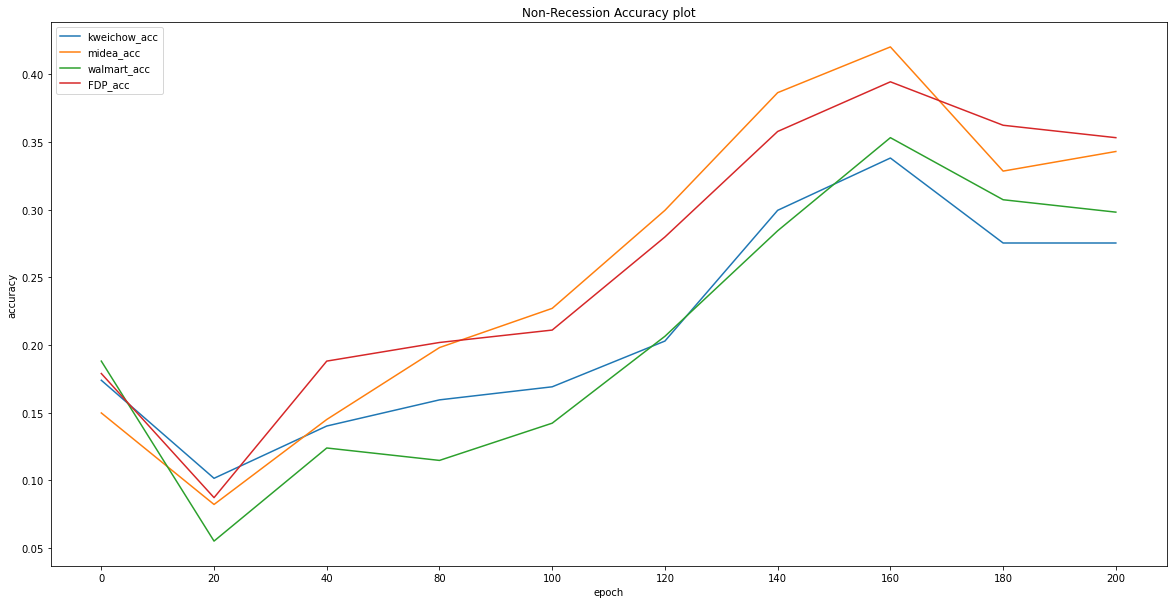

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

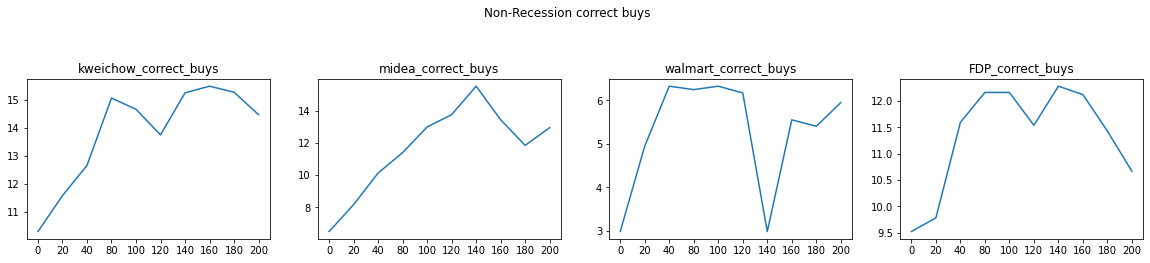

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")


Text(0.5, 1.0, 'FDP_correct_sells')

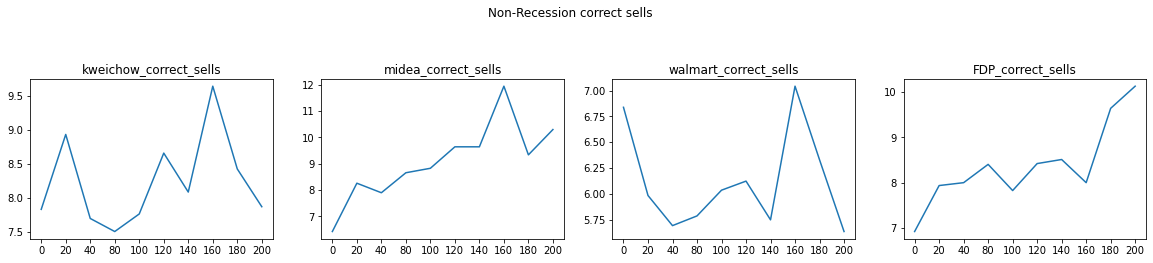

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

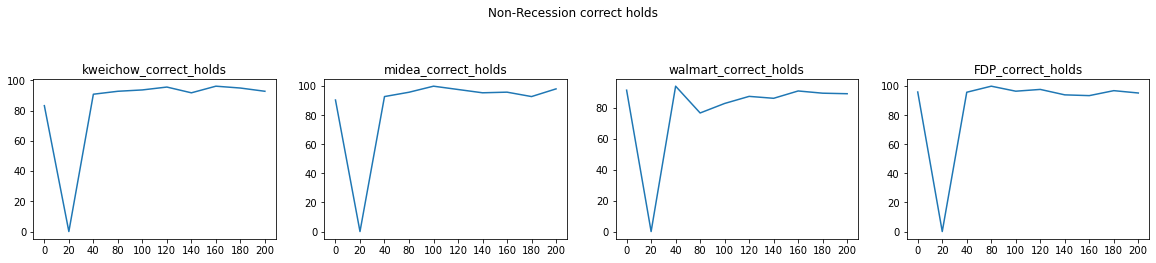

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

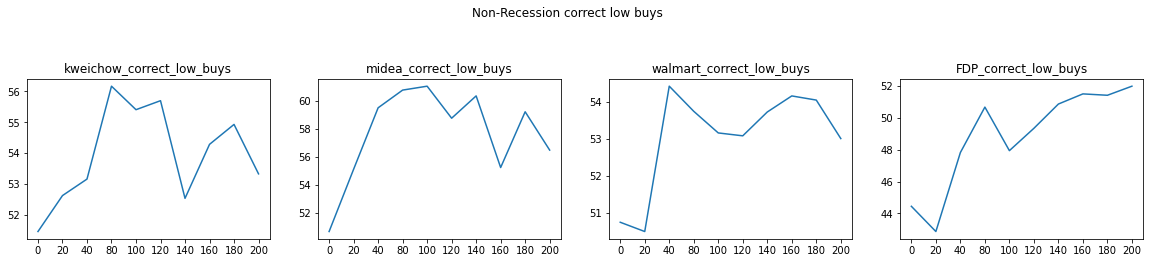

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

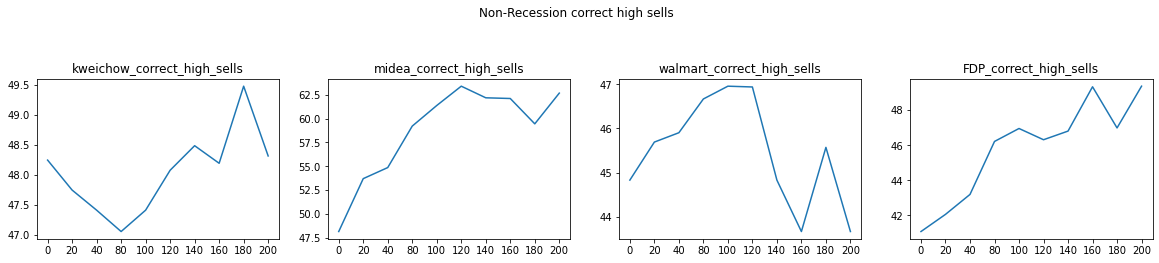

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

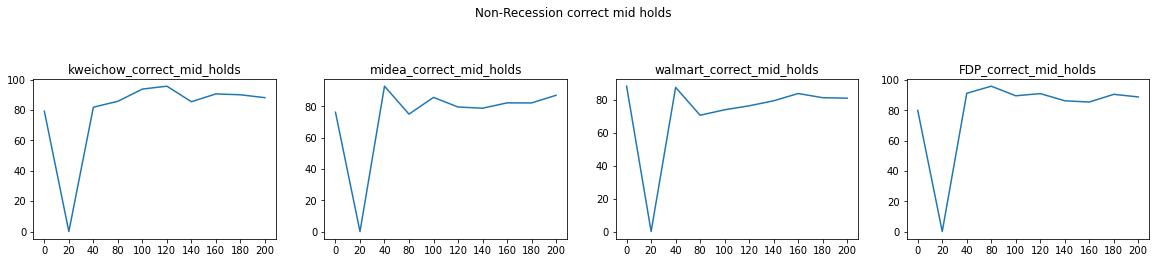

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

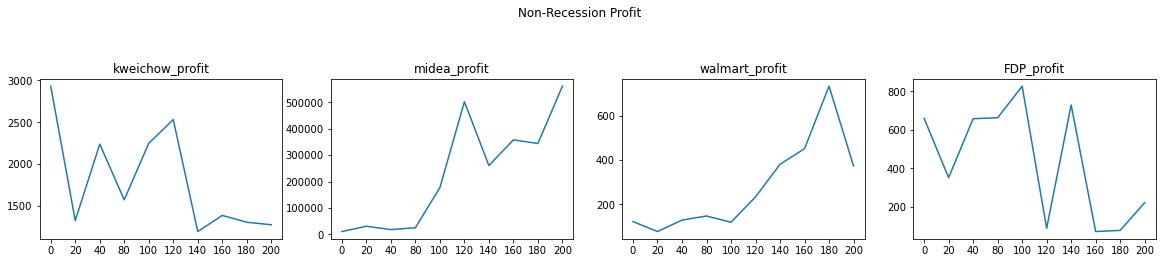

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")

In [31]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 
    
    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3]) 

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


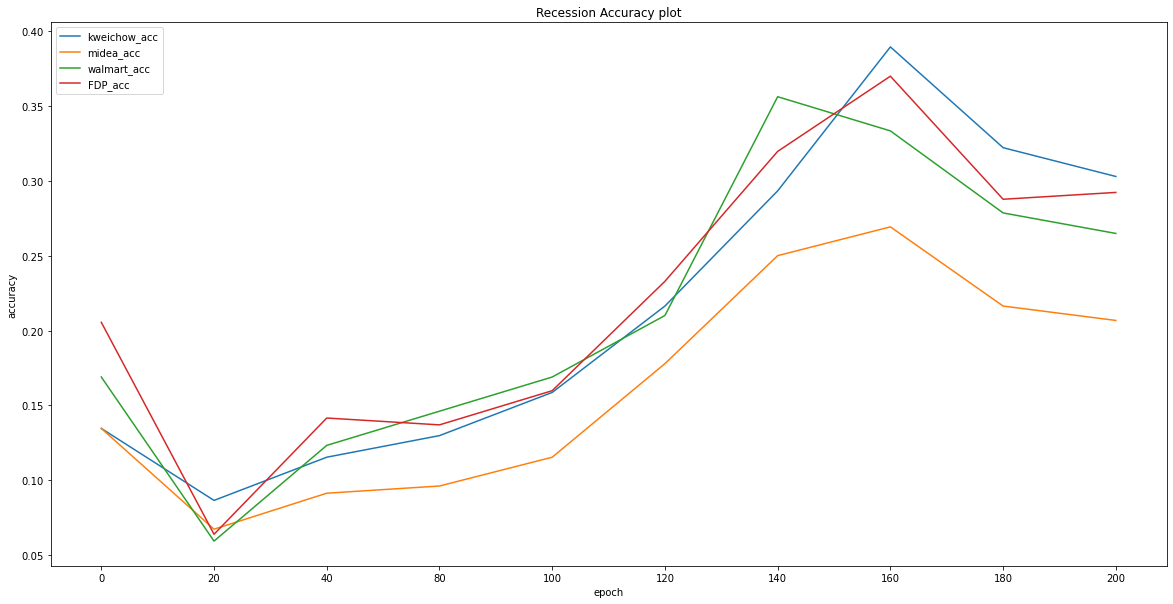

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

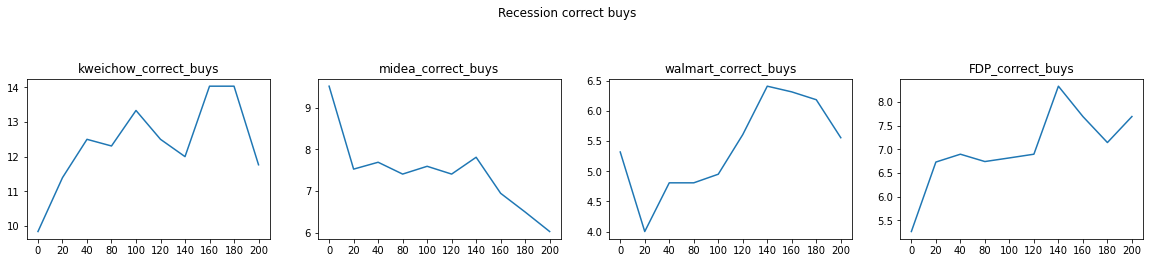

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")

Text(0.5, 1.0, 'FDP_correct_sells')

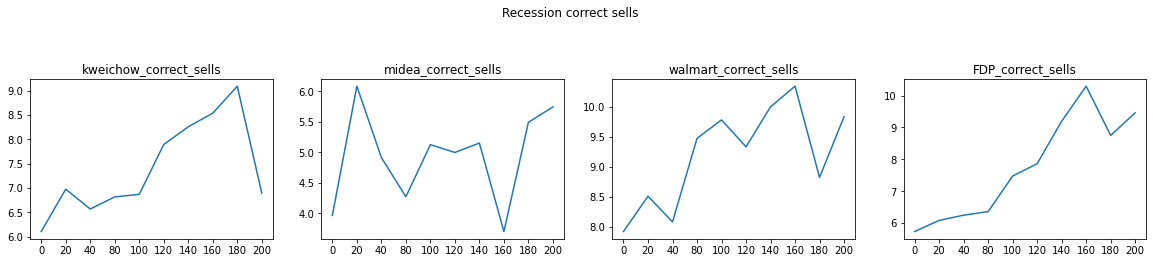

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

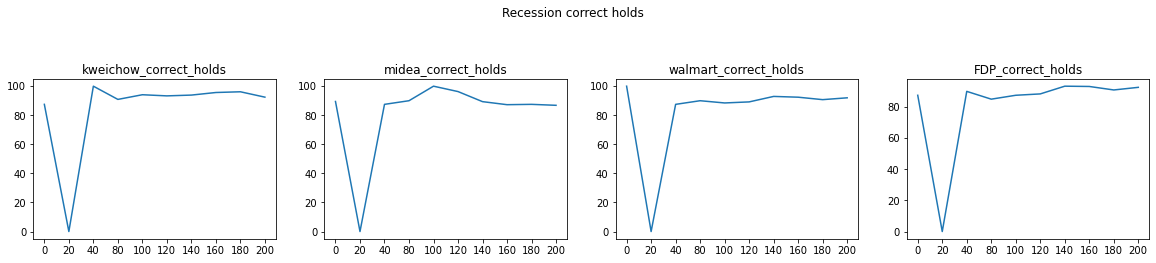

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

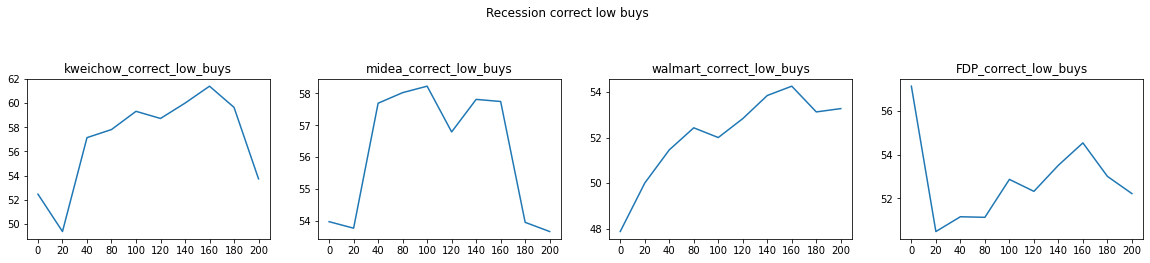

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

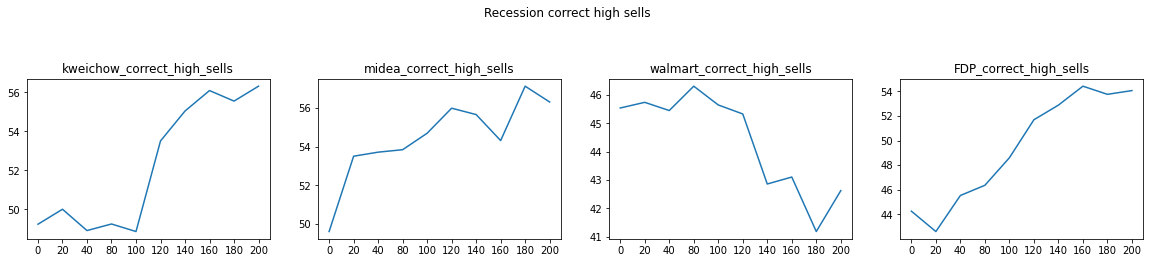

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

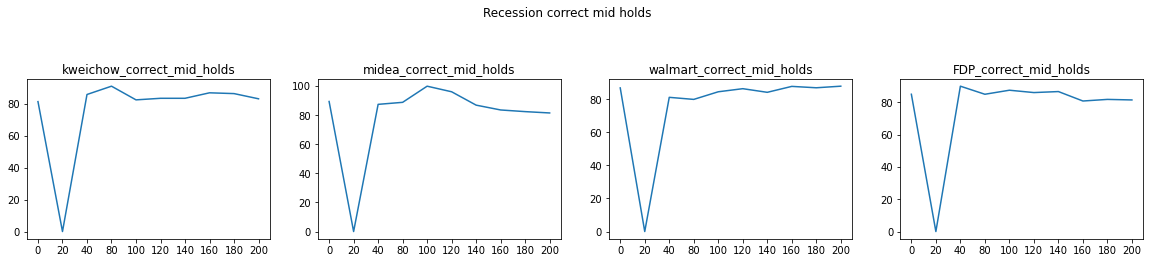

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

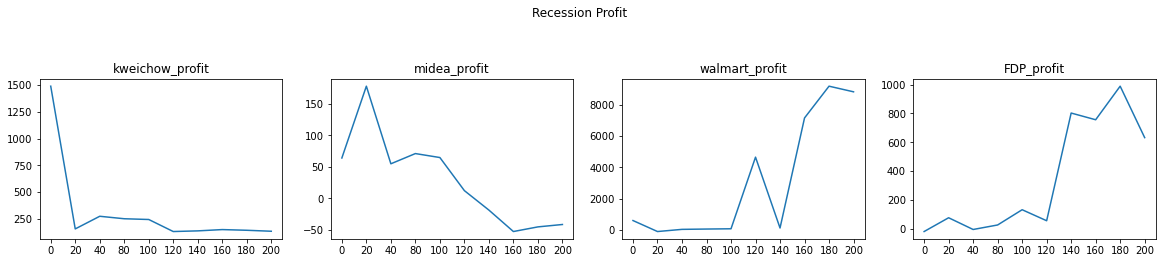

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")